### Bounded flows

Constraining the support of a distribution explicitly can improve the accuracy of models. By doing so, we:

 * Prevent "leakage", where the model assigns mass to regions outside the support.
 * Guarantee valid samples for downstream applications.
 * Add inductive bias that often makes the target easier to learn, e.g. by avoiding issues caused by sudden changes in density at the boundary.

The process used here to explicitly constrain the distribution involves three steps:

 1. Preprocessing the data to map it to an unbounded domain using a bijection.
 2. Learning the flow on the unbounded domain.
 3. Transforming the flow back to the original domain using the inverse of the preprocessing bijection.

As an example, we'll learn a two-dimensional beta distribution with parameters $\alpha=0.4$ and $\beta=0.4$, using samples from the distribution, such that the ground truth model is

$$x_i \sim \text{Beta}(\alpha,\ \beta), \text{ for } i \text{ in } 1,2.$$


Importing the required libraries.

In [99]:
import jax.random as jr
import jax.numpy as jnp
import numpy as onp
from flowjax.flows import MaskedAutoregressiveFlow
from flowjax.distributions import Normal
from flowjax.train import fit_to_data
import matplotlib.pyplot as plt

Generating the toy data.

In [100]:
key, x_key = jr.split(jr.PRNGKey(0))
x = jr.beta(x_key, a=0.4, b=0.4, shape=(5000, 2)) # Supported on the interval [0, 1]^2 

As $x$ has bounded support and much of its mass near the boundaries, we choose a bijection to try and preprocess it to a more reasonable form.

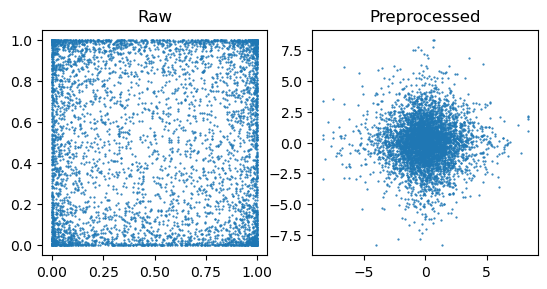

In [101]:
import jax
from flowjax.bijections import Tanh, Affine, Chain, Invert

eps = 1e-7  # Avoid potential numerical issues

preprocess = Chain([
    Affine(loc=-jnp.ones(2) + eps, scale=(1-eps)*jnp.array([2, 2])),  # to [-1+eps, 1-eps]
    Invert(Tanh())   # To ~unbounded
    ])

x_preprocessed = jax.vmap(preprocess.transform)(x)

# Plot the data
fig, axes = plt.subplots(ncols=2)
for (k, v), ax in zip({"Raw": x, "Preprocessed": x_preprocessed}.items(), axes):
    ax.scatter(v[:, 0], v[:, 1], s=0.3)
    ax.set_title(k)
    ax.set_aspect('equal')
    

We can now create and train the flows, we will train one on the unbounded space and another for comparison will be trained directly on the bounded space.

In [102]:
key, subkey = jr.split(jr.PRNGKey(0))

untrained_flow = MaskedAutoregressiveFlow(
    key=subkey,
    base_dist=Normal(jnp.zeros(x.shape[1])),
    transformer=Affine(),
)

key, subkey = jr.split(key)

# Train on the unbounded space
flow, losses = fit_to_data(
    subkey, untrained_flow, x_preprocessed, learning_rate=5e-4, max_patience=10, max_epochs=70
    )

# Train directly on the bounded data
naive_flow, losses = fit_to_data(
    subkey, untrained_flow, x, learning_rate=5e-3, max_patience=10, max_epochs=70
    )

 46%|████▌     | 32/70 [00:04<00:05,  7.32it/s, train=0.0899, val=0.00621 (Max patience reached)]


The flow trained on the unbounded data can be transformed using the inverse of the preprocessing bijection, resulting in the distribution on the original bounded space

In [103]:
from flowjax.distributions import Transformed
bounded_flow = Transformed(flow, Invert(preprocess))

We can visualise the learned densities

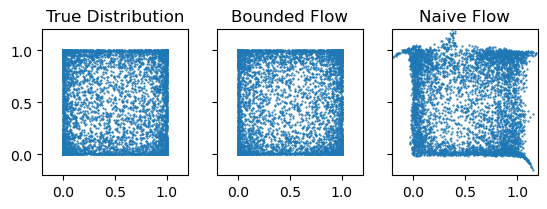

In [105]:
key, *subkeys = jr.split(key, 3)
samples = {
    "True Distribution": x,
    "Bounded Flow": bounded_flow.sample(subkeys[0], (x.shape[0], )),
    "Naive Flow": naive_flow.sample(subkeys[1], (x.shape[0], )),
}

fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True)

for (k, v), ax in zip(samples.items(), axes):
    ax.scatter(v[:, 0], v[:, 1], s=0.3)
    ax.set_title(k)
    ax.set_aspect('equal')

ax.set_xlim((-0.2, 1.2))
ax.set_ylim((-0.2, 1.2))
plt.show()